##Imports

In [ ]:
!pip install transformers

In [ ]:
!pip install transformers[torch]

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import json
import csv
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from transformers import AutoTokenizer
import pickle


# the following code ensures that you can see your (print) results for multiple tasks within a coding block
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


pd.options.display.width = None

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [ ]:
# !pip install pyunpack

In [ ]:
# !pip install patool

##1- Data statistics and preparation

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !gdown https://drive.google.com/uc?id=1QqJw8HQ0qG32_FuOz2HzW2bZdf7UYKa8

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/contract-nli/dev.json
/kaggle/input/contract-nli/train.json
/kaggle/input/contract-nli/test.json


In [ ]:
# from pyunpack import Archive
# import os

# if not os.path.exists("Data"):
#     os.makedirs("Data")

# Archive("contract-nli.zip").extractall("Data")

In [ ]:
# Setting the paths to the input and output directories
input_dir = '/kaggle/input/contract-nli/'
output_dir = '/kaggle/working/'

In [ ]:
def convert_json_to_csv(json_file_name, csv_file_name):
    # Construct the paths to the input and output files
    json_file_path = os.path.join(input_dir, json_file_name)
    csv_file_path = os.path.join(output_dir, csv_file_name)

    # Load the JSON data
    with open(json_file_path, 'r') as f:
        data = json.load(f)

    # Map annotation choices to label values
    label_map = {
        'NotMentioned': 'NotMentioned',
        'Entailment': 'Entailment',
        'Contradiction': 'Contradiction'
    }

    # Extract the relevant information from the JSON data
    rows = []
    for document in data['documents']:
        text = document['text']
        annotation_sets = document['annotation_sets']
        for annotation_set in annotation_sets:
            annotations = annotation_set['annotations']
            for annotation_id, annotation in annotations.items():
                if annotation_id in data['labels']:
                    choice = annotation['choice']
                    label = label_map.get(choice, 'NotMentioned')
                    hypothesis = data['labels'][annotation_id]['hypothesis']
                    evidence_spans = annotation['spans']
                    rows.append([text, hypothesis, label, evidence_spans])

    # Write the data to a CSV file
    with open(csv_file_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(['text', 'hypothesis', 'label', 'evidence_spans'])
        writer.writerows(rows)



In [ ]:
convert_json_to_csv('train.json', 'train.csv')
convert_json_to_csv('dev.json', 'dev.csv')
convert_json_to_csv('test.json', 'test.csv')

In [ ]:
train_df = pd.read_csv('/kaggle/working/train.csv')
validation_df = pd.read_csv('/kaggle/working/dev.csv')
testing_df = pd.read_csv('/kaggle/working/test.csv')

In [ ]:
testing_df

,text,hypothesis,label,evidence_spans
0,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not reverse engineer any...,NotMentioned,[]
1,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall destroy or return some C...,Entailment,"[84, 85, 86]"
2,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Agreement shall not grant Receiving Party any ...,Entailment,[45]
3,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Receiving Party shall not disclose the fact th...,NotMentioned,[]
4,NON-DISCLOSURE AGREEMENT\nRequired under JEA's...,Confidential Information shall only include te...,Contradiction,"[25, 32]"
...,...,...,...,...
2086,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may create a copy of some Conf...,NotMentioned,[]
2087,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party shall notify Disclosing Party ...,Entailment,[32]
2088,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may acquire information simila...,Entailment,"[15, 19]"
2089,EXECUTION VERSION\nNON-DISCLOSURE AND CONFIDEN...,Receiving Party may share some Confidential In...,Entailment,"[14, 30]"


### How the CSVs are created :

* I created a function called conver_json_to_csv this function does the following:

  * Takes 2 arugments which are the json file path, and the output csv file path

  * it starts by loading json data
  * Loops through each document in the json data where data['documents'] is a list of dictionaries, with each dictionary representing a document.

  * Extracts the text field from the current document storing it in a varibale called Text , and the text is the string represnting the text of the current document "contract"

  * Extracts the annotation_sets field from the current document

  * Loops through each annotation set in the current document where annotations is a dictionary of annotations, with each key being an annotation ID and each value being a dictionary representing an annotation.

  * Loops through each annotation in the current annotation set

  * Checks if the current annotation has a corresponding label in the data['labels'] dictionary

  * Extracts the choice field from the current annotation

  * Maps the choice field to a label value using the label_map dictionary

### Statistics

In [ ]:
# The number of documents in each set

print(f'The Training dataset has {train_df["text"].shape[0]} documents')
print(f'The Development dataset has {validation_df["text"].shape[0]} documents')
print(f'The Testing dataset has {testing_df["text"].shape[0]} documents')


The Training dataset has 7191 documents
The Development dataset has 1037 documents
The Testing dataset has 2091 documents


In [ ]:
# The average document lenght in each dataset

train_avg_doc_length = train_df["text"].str.len().mean()
dev_avg_doc_length = validation_df["text"].str.len().mean()
test_avg_doc_length = testing_df["text"].str.len().mean()


print(f"The Training dataset has an average document length of {train_avg_doc_length:.2f} characters")
print(f"The Development dataset has an average document length of {dev_avg_doc_length:.2f} characters")
print(f"The Test dataset has an average document length of {test_avg_doc_length:.2f} characters")

The Training dataset has an average document length of 11049.29 characters
The Development dataset has an average document length of 12094.97 characters
The Test dataset has an average document length of 11218.21 characters


In [ ]:
# The max document lenght in each dataset
train_max_doc_length = train_df["text"].str.len().max()
dev_max_doc_length = validation_df["text"].str.len().max()
test_max_doc_length = testing_df["text"].str.len().max()

print(f"The Training dataset has max document length of {train_max_doc_length:.2f} characters")
print(f"The Development dataset has max document length of {dev_max_doc_length:.2f} characters")
print(f"The Test dataset has max document length of {test_max_doc_length:.2f} characters")

The Training dataset has max document length of 54571.00 characters
The Development dataset has max document length of 32359.00 characters
The Test dataset has max document length of 41779.00 characters


In [ ]:
# The min document lenght in each dataset
train_min_doc_length = train_df["text"].str.len().min()
dev_min_doc_length = validation_df["text"].str.len().min()
test_min_doc_length = testing_df["text"].str.len().min()

print(f"The Training dataset has min document length of {train_min_doc_length:.2f} characters")
print(f"The Development dataset has min document length of {dev_min_doc_length:.2f} characters")
print(f"The Test dataset has min document length of {test_min_doc_length:.2f} characters")

The Training dataset has min document length of 1481.00 characters
The Development dataset has min document length of 2270.00 characters
The Test dataset has min document length of 1231.00 characters


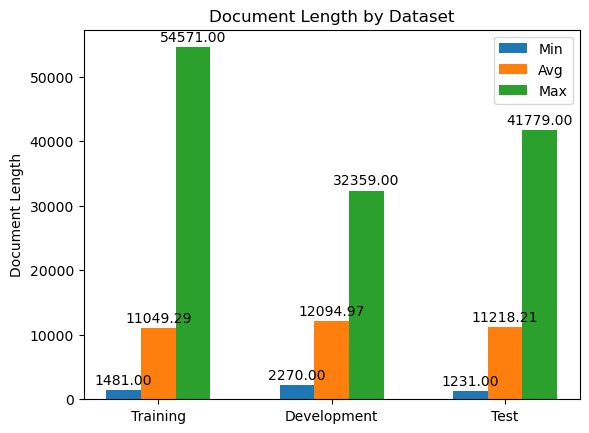

In [ ]:
## plotting
# Set up the data for the grouped bar chart
min_vals = [train_min_doc_length, dev_min_doc_length, test_min_doc_length]
max_vals = [train_max_doc_length, dev_max_doc_length, test_max_doc_length]
avg_vals = [train_avg_doc_length, dev_avg_doc_length, test_avg_doc_length]
labels = ["Training", "Development", "Test"]
x = np.arange(len(labels))
width = 0.20

# Plot the grouped bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, min_vals, width, label='Min')
rects2 = ax.bar(x, avg_vals, width, label='Avg')
rects3 = ax.bar(x + width, max_vals, width, label='Max')

# Add labels, title, and legend
ax.set_ylabel('Document Length')
ax.set_title('Document Length by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# Add value labels on top of the bars
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 2),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_value_labels(rects1)
add_value_labels(rects2)
add_value_labels(rects3)

plt.show();

In [ ]:
# The average hypothesis lenght in each dataset

train_avg_hyp_length = train_df["hypothesis"].str.len().mean()
dev_avg_hyp_length = validation_df["hypothesis"].str.len().mean()
test_avg_hyp_length = testing_df["hypothesis"].str.len().mean()


print(f"The Training dataset has an average hypothesis length of {train_avg_hyp_length:.2f} characters")
print(f"The Development dataset has an average hypothesis length of {dev_avg_hyp_length:.2f} characters")
print(f"The Test dataset has an average hypothesis length of {test_avg_doc_length:.2f} characters")

The Training dataset has an average hypothesis length of 97.18 characters
The Development dataset has an average hypothesis length of 97.18 characters
The Test dataset has an average hypothesis length of 11218.21 characters


In [ ]:
# The max hypothesis lenght in each dataset

train_max_hyp_length = train_df["hypothesis"].str.len().max()
dev_max_hyp_length = validation_df["hypothesis"].str.len().max()
test_max_hyp_length = testing_df["hypothesis"].str.len().max()


print(f"The Training dataset has max hypothesis length of {train_max_hyp_length:.2f} characters")
print(f"The Development dataset has max hypothesis length of {dev_max_hyp_length:.2f} characters")
print(f"The Test dataset has max hypothesis length of {test_max_hyp_length:.2f} characters")

The Training dataset has max hypothesis length of 162.00 characters
The Development dataset has max hypothesis length of 162.00 characters
The Test dataset has max hypothesis length of 162.00 characters


In [ ]:
# The min hypothesis lenght in each dataset

train_min_hyp_length = train_df["hypothesis"].str.len().min()
dev_min_hyp_length = validation_df["hypothesis"].str.len().min()
test_min_hyp_length = testing_df["hypothesis"].str.len().min()


print(f"The Training dataset has max hypothesis length of {train_min_hyp_length:.2f} characters")
print(f"The Development dataset has max hypothesis length of {dev_min_hyp_length:.2f} characters")
print(f"The Test dataset has max hypothesis length of {test_min_hyp_length:.2f} characters")

The Training dataset has max hypothesis length of 66.00 characters
The Development dataset has max hypothesis length of 66.00 characters
The Test dataset has max hypothesis length of 66.00 characters


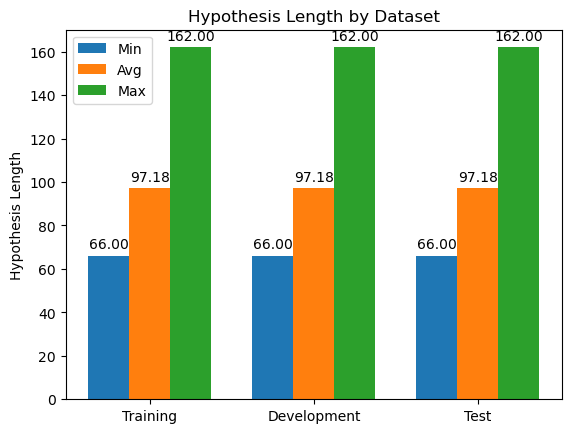

In [ ]:
## plotting
# Set up the data for the grouped bar chart
min_vals = [train_min_hyp_length, dev_min_hyp_length, test_min_hyp_length]
max_vals = [train_max_hyp_length, dev_max_hyp_length, test_max_hyp_length]
avg_vals = [train_avg_hyp_length, dev_avg_hyp_length, test_avg_hyp_length]
labels = ["Training", "Development", "Test"]
x = np.arange(len(labels))
width = 0.25

# Plot the grouped bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, min_vals, width, label='Min')
rects2 = ax.bar(x, avg_vals, width, label='Avg')
rects3 = ax.bar(x + width, max_vals, width, label='Max')

# Add labels, title, and legend
ax.set_ylabel('Hypothesis Length')
ax.set_title('Hypothesis Length by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


# Add value labels on top of the bars
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_value_labels(rects1)
add_value_labels(rects2)
add_value_labels(rects3)

plt.show();

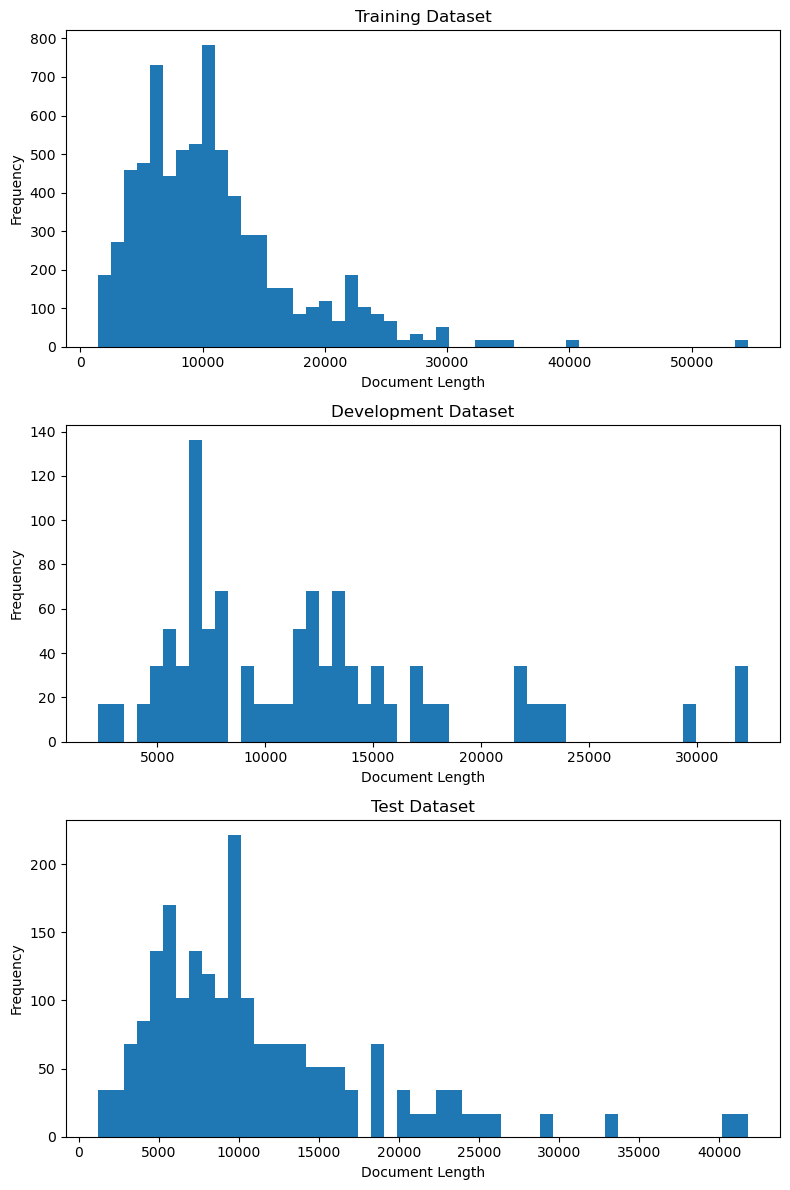

In [ ]:
## The distribuation of the Documents lenghts in The datasets

# the document lengths for each dataset
train_doc_lengths = train_df["text"].str.len()
dev_doc_lengths = validation_df["text"].str.len()
test_doc_lengths = testing_df["text"].str.len()

# histograms
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].hist(train_doc_lengths, bins=50)
axs[0].set_title('Training Dataset')
axs[0].set_xlabel('Document Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(dev_doc_lengths, bins=50)
axs[1].set_title('Development Dataset')
axs[1].set_xlabel('Document Length')
axs[1].set_ylabel('Frequency')

axs[2].hist(test_doc_lengths, bins=50)
axs[2].set_title('Test Dataset')
axs[2].set_xlabel('Document Length')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show();

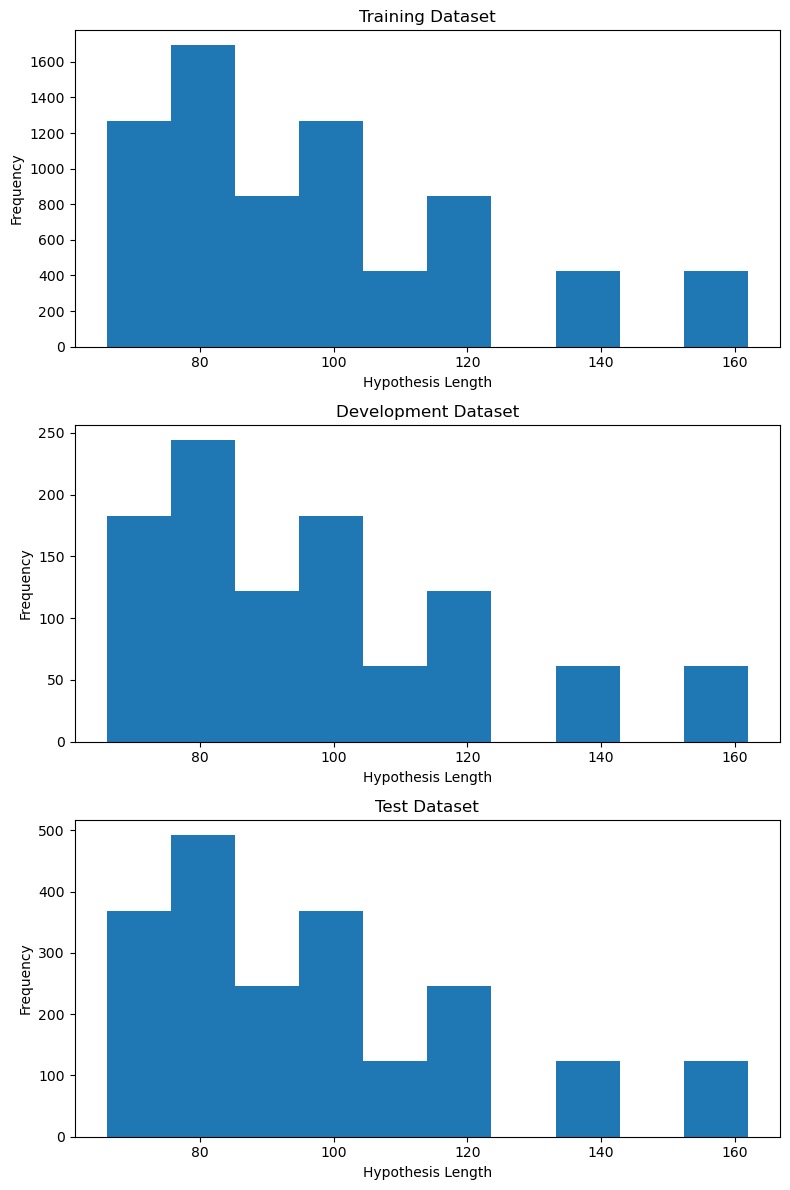

In [ ]:
## The distribuation of the Hypothesis lenghts in The datasets

# the Hypothesis lengths for each dataset
train_hyp_lengths = train_df["hypothesis"].str.len()
dev_hyp_lengths = validation_df["hypothesis"].str.len()
test_hyp_lengths = testing_df["hypothesis"].str.len()

# histograms
fig, axs = plt.subplots(3, 1, figsize=(8, 12))
axs[0].hist(train_hyp_lengths, bins=10)
axs[0].set_title('Training Dataset')
axs[0].set_xlabel('Hypothesis Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(dev_hyp_lengths, bins=10)
axs[1].set_title('Development Dataset')
axs[1].set_xlabel('Hypothesis Length')
axs[1].set_ylabel('Frequency')

axs[2].hist(test_hyp_lengths, bins=10)
axs[2].set_title('Test Dataset')
axs[2].set_xlabel('Hypothesis Length')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show();

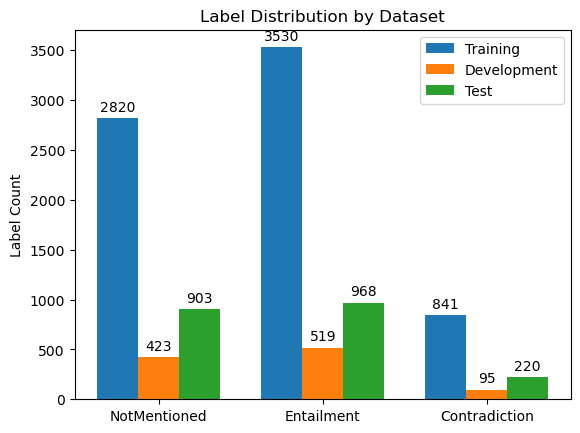

In [ ]:
## The count of each label in each dataset

# the label counts for each dataset
train_label_counts = train_df["label"].value_counts()
dev_label_counts = validation_df["label"].value_counts()
test_label_counts = testing_df["label"].value_counts()

#list of the labels
labels = ['NotMentioned', 'Entailment', 'Contradiction']

# the data for the grouped bar chart
train_vals = [train_label_counts[label] for label in labels]
dev_vals = [dev_label_counts[label] for label in labels]
test_vals = [test_label_counts[label] for label in labels]
x = np.arange(len(labels))
width = 0.25

# Plot the grouped bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - width, train_vals, width, label='Training')
rects2 = ax.bar(x, dev_vals, width, label='Development')
rects3 = ax.bar(x + width, test_vals, width, label='Test')

# Add labels, title, and legend
ax.set_ylabel('Label Count')
ax.set_title('Label Distribution by Dataset')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Add value labels on top of the bars
def add_value_labels(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
add_value_labels(rects1)
add_value_labels(rects2)
add_value_labels(rects3)

plt.show();

## 2-  Performing NLI using two transformer based approaches

**I would choose**

* BERT
* RoBERTa

#### The reason for choosing these models :     

* **AlBert** : as it achived SOA results on several NLI benchmarks such as [MLI "Multi-Genre NAtural LAngauge Inference", SNLI "Stanford Natural Language Inference"] and Albert is designed to be more efficient than BERT, with a smaller number of parameters and faster training times. and also it uses cross-layer parameter sharing, which helps reduce the number of parameters required for the model and can improve its ability to generalize to new inputs

* **RoBERTa** : simillar as Bert but uses a larger pre-training corpus and a different pre-training objective, achived SOA results on several NLI benchmarks such as [MNLI dataset and  GLUE benchmark], and it is  pre-trained using a MLM objective, but unlike BERT, it uses dynamic masking during pre-training and does not use the NSP objective.

### First Albert:

In [ ]:
# Load the pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")
model = AutoModelForSequenceClassification.from_pretrained("albert-base-v2", num_labels=3)

Some weights of the model checkpoint at albert-base-v2 were not used when initializing AlbertForSequenceClassification: ['predictions.decoder.bias', 'predictions.dense.bias', 'predictions.bias', 'predictions.dense.weight', 'predictions.LayerNorm.bias', 'predictions.LayerNorm.weight']
- This IS expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model 

In [ ]:
# Tokenize the data
import torch


def tokenize_data(data):
    #the text and hypothesis will speperated by [sep] token to differentiate them.
    return tokenizer(text=data['text'].tolist(), text_pair=data['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)

In [ ]:
class ContractNLIDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(value[idx]) for key, value in self.encodings.items()}
        # Here we ensure the label is an integer tensor
        item['labels'] = torch.tensor(int(self.labels[idx]))
        return item

    def __len__(self):
        return len(self.labels)

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

train_labels = [label_mapping[label] for label in train_df['label'].tolist()]
valid_labels = [label_mapping[label] for label in validation_df['label'].tolist()]
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)

In [ ]:
train_dataset.encodings[0]

Encoding(num_tokens=512, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [ ]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    evaluation_strategy='steps',
    eval_steps=50,
    learning_rate=2e-5,
    save_total_limit=1,
    load_best_model_at_end=True,
)


In [ ]:
# Define the evaluation metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    return {"accuracy": (preds == p.label_ids).mean()}

In [ ]:
trainer_albert = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer_albert.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You're using a AlbertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
50,0.999300,0.956185,0.505304
100,0.915200,0.880160,0.599807
150,0.856500,0.835279,0.621986
200,0.829400,0.828925,0.608486
250,0.714700,0.755196,0.684667
300,0.711200,0.741662,0.665381
350,0.671600,0.674912,0.706847
400,0.694200,0.684280,0.697203
450,0.739000,0.706682,0.667310
500,0.682900,0.683268,0.673095


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=675, training_loss=0.7547231282128228, metrics={'train_runtime': 1505.2066, 'train_samples_per_second': 14.332, 'train_steps_per_second': 0.448, 'total_flos': 515604712633344.0, 'train_loss': 0.7547231282128228, 'epoch': 3.0})

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(model, eval_dataset):
    # Create a Trainer object
    trainer = Trainer(model=model)


    # Making predictions on the evaluation dataset
    eval_predictions = trainer.predict(eval_dataset)
    eval_preds = eval_predictions.predictions.argmax(axis=-1)

    # Extracting the true labels and convert to numpy array
    eval_labels = [d['labels'] for d in eval_dataset]
    eval_labels = np.array(eval_labels).flatten()

    # Calculating model accuracy
    model_accuracy = accuracy_score(eval_labels, eval_preds) * 100

    # Calculating model precision, recall and f1 score using "weighted" average
    model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(eval_labels, eval_preds, average='weighted')

    # Create a dictionary of evaluation metrics
    model_results = {"accuracy": model_accuracy,
                     "precision": model_precision,
                     "recall": model_recall,
                     "f1": model_f1}
    return model_results

In [ ]:
label_mapping = {"NotMentioned": 0, "Entailment": 1, "Contradiction": 2}

In [ ]:
test_encodings = tokenizer(text=testing_df['text'].tolist(), text_pair=testing_df['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)
test_labels = [label_mapping[label] for label in testing_df['label'].tolist()]
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
# Eavluating bert model on Test dataset
eval_results = calculate_results(model,test_dataset)
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'accuracy': 68.77092300334769, 'precision': 0.697075351285527, 'recall': 0.6877092300334768, 'f1': 0.6773320056504287}


In [ ]:
# Eavluating bert model on validation dataset
eval_results = calculate_results(model,valid_dataset)
print(eval_results)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'accuracy': 67.30954676952749, 'precision': 0.6741581542561965, 'recall': 0.6730954676952748, 'f1': 0.6662517498480028}


### second RoBERTa:

In [ ]:
# Loading the pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("roberta-base")
model2 = AutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=3)


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.bias', 'classifier.dense.weight', 'classifier.out_proj.weight', 'classifier.dense.bias']
You should pr

In [ ]:
train_labels = [label_mapping[label] for label in train_df['label'].tolist()]
valid_labels = [label_mapping[label] for label in validation_df['label'].tolist()]
train_encodings = tokenize_data(train_df)
valid_encodings = tokenize_data(validation_df)

In [ ]:
train_dataset = ContractNLIDataset(train_encodings, train_labels)
valid_dataset = ContractNLIDataset(valid_encodings, valid_labels)

In [ ]:
# def compute_metrics(eval_preds):
#     predictions, labels = eval_preds
#     preds = predictions.argmax(-1)
#     accuracy = accuracy_score(labels, preds)
#     return {"accuracy": accuracy}

In [ ]:
trainer_roberta = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    compute_metrics=compute_metrics
)

In [ ]:
trainer_roberta.train()

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy
50,1.088300,1.083355,0.407907
100,0.980600,0.929387,0.500482
150,0.941500,0.920381,0.527483
200,0.884400,0.895002,0.565092
250,0.759100,0.757545,0.657666
300,0.693500,0.686275,0.693346
350,0.677100,0.685033,0.674060
400,0.733000,0.685409,0.679846
450,0.676700,0.688167,0.679846
500,0.699300,0.647702,0.721311


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=675, training_loss=0.7809906214254874, metrics={'train_runtime': 1434.3269, 'train_samples_per_second': 15.041, 'train_steps_per_second': 0.471, 'total_flos': 5676145760646144.0, 'train_loss': 0.7809906214254874, 'epoch': 3.0})

In [ ]:
test_encodings = tokenizer(text=testing_df['text'].tolist(), text_pair=testing_df['hypothesis'].tolist(), truncation=True, padding="max_length", max_length=512)
test_labels = [label_mapping[label] for label in testing_df['label'].tolist()]
test_dataset = ContractNLIDataset(test_encodings, test_labels)

In [ ]:
# Evaluating roberta model on the testset
eval_results = calculate_results(model2,test_dataset)
print(eval_results)

Exception ignored in: <function _xla_gc_callback at 0x7a2759220af0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/jax/_src/lib/__init__.py", line 104, in _xla_gc_callback
    xla_client._xla.collect_garbage()
KeyboardInterrupt: 


{'accuracy': 70.77953132472501, 'precision': 0.7045002527143147, 'recall': 0.7077953132472501, 'f1': 0.7050484286579407}


In [ ]:
# Evaluating roberta model on the validation
eval_results = calculate_results(model2,valid_dataset)
print(eval_results)

{'accuracy': 72.1311475409836, 'precision': 0.7202797094991559, 'recall': 0.7213114754098361, 'f1': 0.7200741552350322}


### 3- Performance Analysis and Error Anaylsis

#### Finding where the model gets wrong : Roberta model


In [ ]:
model_name = trainer_roberta.model.__class__.__name__
print(model_name)

RobertaForSequenceClassification


In [ ]:
# Redefine the label mapping
label_mapping = {0: "NotMentioned", 1: "Entailment", 2: "Contradiction"}

In [ ]:
# Getting the wrong preds
incorrect_preds_list = []
predictions, label_ids, metrics = trainer_roberta.predict(valid_dataset)

if len(predictions) == 0:
    print("No predictions were made.")
else:
    # Convert the label ids to numpy array
    valid_labels = np.array([int(label_id) for label_id in label_ids])

    # Get the predicted labels
    pred_labels = np.argmax(predictions, axis=1)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


In [ ]:
# Comparing the predicted labels with the actual labels
for i in range(len(valid_labels)):
    if pred_labels[i] != valid_labels[i]:
        text = validation_df.iloc[i]['text']
        hypothesis = validation_df.iloc[i]['hypothesis']
        actual_label = label_mapping[valid_labels[i]]
        pred_label = label_mapping[pred_labels[i]]
        incorrect_preds_list.append({'Text': text, 'Hypothesis': hypothesis, 'Actual Label': actual_label, 'Predicted Label': pred_label})

# Converting the list DataFrame
incorrect_preds_df = pd.DataFrame(incorrect_preds_list)
incorrect_preds_df

,Text,Hypothesis,Actual Label,Predicted Label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NotMentioned
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,All Confidential Information shall be expressl...,Entailment,Contradiction
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party may retain some Confidential I...,Entailment,Contradiction
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party may create a copy of some Conf...,Entailment,NotMentioned
...,...,...,...,...
284,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,Receiving Party may retain some Confidential I...,NotMentioned,Entailment
285,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,Receiving Party may share some Confidential In...,NotMentioned,Entailment
286,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,Receiving Party shall notify Disclosing Party ...,NotMentioned,Entailment
287,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,Receiving Party shall not use any Confidential...,NotMentioned,Entailment


#### Investigating where the model mostly goes wrong

In [ ]:
# create a cross tab between actual and predicted labels
crosstab_df = pd.crosstab(incorrect_preds_df['Actual Label'], incorrect_preds_df['Predicted Label'])
print(crosstab_df)

Predicted Label  Contradiction  Entailment  NotMentioned
Actual Label                                            
Contradiction                0          25            22
Entailment                  10           0           115
NotMentioned                19          98             0


 from the previous we can see that the model mostly goes wrong when
 * The Actual label was `NotMentioned` and predicted it as `Entailment`
 * The Actual label was `Entailment` and predicted it as `NotMentioned`


so we can see that the model reverses everu Enatilment as NotMentioned and vice versa .

In [ ]:
# let's invesigate these cases and see first :The Actual label was NotMentioned and predicted it as Entailment
case_1 = incorrect_preds_df[(incorrect_preds_df['Actual Label']== 'NotMentioned')& (incorrect_preds_df['Predicted Label']=='Entailment') ]


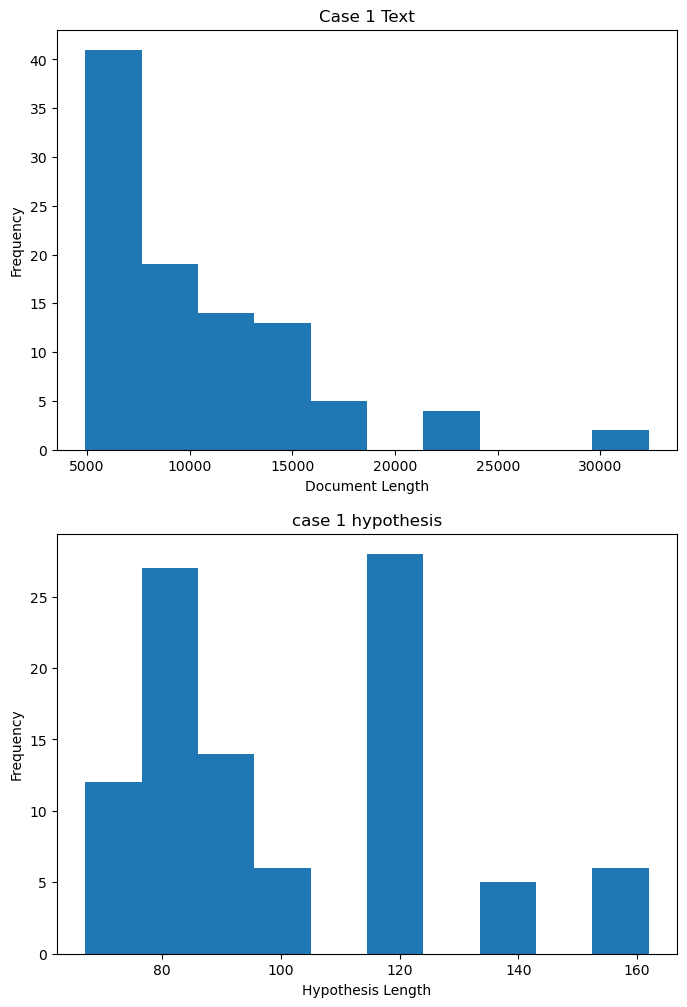

In [ ]:
# visaluizing the distibuation of hypothesis lenght and Text length
case_1_text_lengths = case_1["Text"].str.len()
case_1_Hypothesis_lengths = case_1["Hypothesis"].str.len()

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].hist(case_1_text_lengths, bins=10)
axs[0].set_title('Case 1 Text')
axs[0].set_xlabel('Document Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(case_1_Hypothesis_lengths, bins=10)
axs[1].set_title('case 1 hypothesis')
axs[1].set_xlabel('Hypothesis Length')
axs[1].set_ylabel('Frequency')



plt.show;

For the first case we can see that the most frequent text length for this error is around 5000 while the hypothese length of 80 and 120

In [ ]:
# let's invesigate second :The Actual label was Entailment  and predicted it as  NotMentioned
case_2 = incorrect_preds_df[(incorrect_preds_df['Actual Label']== 'Entailment')& (incorrect_preds_df['Predicted Label']=='NotMentioned') ]
case_2

,Text,Hypothesis,Actual Label,Predicted Label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NotMentioned
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party may create a copy of some Conf...,Entailment,NotMentioned
6,NON-DISCLOSURE AGREEMENT\nTHIS AGREEMENT is ma...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
7,NON-DISCLOSURE AGREEMENT\nTHIS AGREEMENT is ma...,Receiving Party shall not disclose the fact th...,Entailment,NotMentioned
...,...,...,...,...
268,Exhibit 99(d)(7)\nNON-DISCLOSURE AGREEMENT\nTh...,Receiving Party shall not solicit some of Disc...,Entailment,NotMentioned
269,Exhibit 10.24\nCONFIDENTIALITY AND NON-DISCLOS...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
272,Exhibit 10.24\nCONFIDENTIALITY AND NON-DISCLOS...,Receiving Party shall notify Disclosing Party ...,Entailment,NotMentioned
275,Exhibit (d)(5)\nCONFIDENTIALITY AGREEMENT\nDec...,Receiving Party shall notify Disclosing Party ...,Entailment,NotMentioned


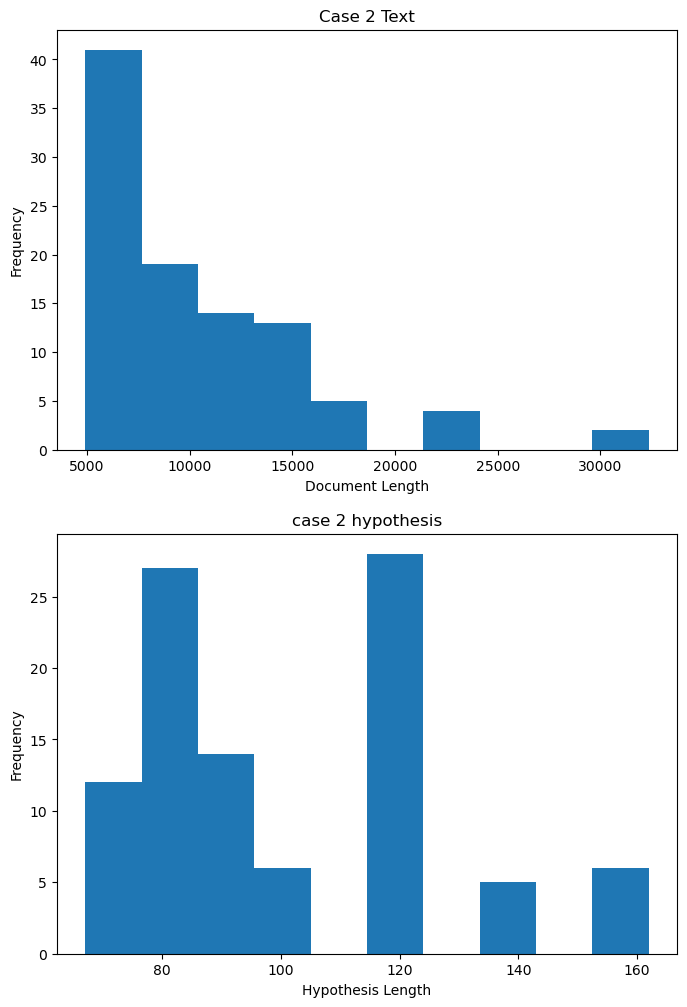

In [ ]:
# visaluizing the distibuation of hypothesis lenght and Text length
case_2_text_lengths = case_2["Text"].str.len()
case_2_Hypothesis_lengths = case_2["Hypothesis"].str.len()

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].hist(case_1_text_lengths, bins=10)
axs[0].set_title('Case 2 Text')
axs[0].set_xlabel('Document Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(case_1_Hypothesis_lengths, bins=10)
axs[1].set_title('case 2 hypothesis')
axs[1].set_xlabel('Hypothesis Length')
axs[1].set_ylabel('Frequency')



plt.show;

We got the same numbers as for the first case so i belive that there is no thing replated either to the length of text or the length of hypothesis

#### Finding where the model gets wrong : ALBert model


In [ ]:
model_name = trainer_albert .model.__class__.__name__
print(model_name)

AlbertForSequenceClassification


In [ ]:
# Redefine the label mapping
label_mapping = {0: "NotMentioned", 1: "Entailment", 2: "Contradiction"}

In [ ]:
# Getting the wrong preds
incorrect_preds_list = []
predictions, label_ids, metrics = trainer_albert.predict(valid_dataset)

if len(predictions) == 0:
    print("No predictions were made.")
else:
    # Convert the label ids to numpy array
    valid_labels = np.array([int(label_id) for label_id in label_ids])

    # Get the predicted labels
    pred_labels = np.argmax(predictions, axis=1)

In [ ]:
# Comparing the predicted labels with the actual labels
for i in range(len(valid_labels)):
    if pred_labels[i] != valid_labels[i]:
        text = validation_df.iloc[i]['text']
        hypothesis = validation_df.iloc[i]['hypothesis']
        actual_label = label_mapping[valid_labels[i]]
        pred_label = label_mapping[pred_labels[i]]
        incorrect_preds_list.append({'Text': text, 'Hypothesis': hypothesis, 'Actual Label': actual_label, 'Predicted Label': pred_label})

# Converting the list DataFrame
incorrect_preds_df = pd.DataFrame(incorrect_preds_list)
incorrect_preds_df

,Text,Hypothesis,Actual Label,Predicted Label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NotMentioned
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,All Confidential Information shall be expressl...,Entailment,NotMentioned
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information may include verbally ...,Entailment,NotMentioned
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party may create a copy of some Conf...,Entailment,NotMentioned
...,...,...,...,...
334,NON-DISCLOSURE AGREEMENT\n1. Introduction. Thi...,Receiving Party shall not use any Confidential...,NotMentioned,Entailment
335,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Receiving Party shall destroy or return some C...,NotMentioned,Entailment
336,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Receiving Party shall not solicit some of Disc...,NotMentioned,Entailment
337,Exhibit (e)(3)\nMUTUAL NONDISCLOSURE AGREEMENT...,Receiving Party may create a copy of some Conf...,NotMentioned,Entailment


#### Investigating where the model mostly goes wrong

In [ ]:
# create a cross tab between actual and predicted labels
crosstab_df = pd.crosstab(incorrect_preds_df['Actual Label'], incorrect_preds_df['Predicted Label'])
print(crosstab_df)

Predicted Label  Contradiction  Entailment  NotMentioned
Actual Label                                            
Contradiction                0          33            20
Entailment                   6           0            97
NotMentioned                12         171             0


 from the previous we can see that the model mostly goes wrong when
 * The Actual label was `NotMentioned` and predicted it as `Entailment`
 * The Actual label was `Entailment` and predicted it as `NotMentioned`


so we can see that the model reverses everu Enatilment as NotMentioned and vice versa .

In [ ]:
# let's invesigate these cases and see first :The Actual label was NotMentioned and predicted it as Entailment
case_1 = incorrect_preds_df[(incorrect_preds_df['Actual Label']== 'NotMentioned')& (incorrect_preds_df['Predicted Label']=='Entailment') ]


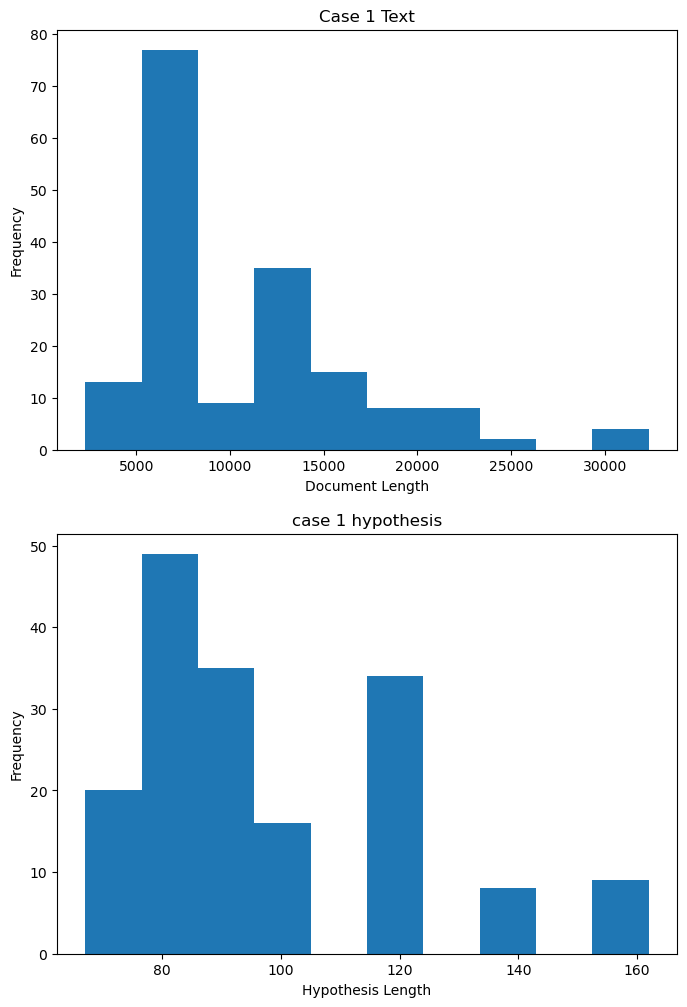

In [ ]:
# visaluizing the distibuation of hypothesis lenght and Text length
case_1_text_lengths = case_1["Text"].str.len()
case_1_Hypothesis_lengths = case_1["Hypothesis"].str.len()

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].hist(case_1_text_lengths, bins=10)
axs[0].set_title('Case 1 Text')
axs[0].set_xlabel('Document Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(case_1_Hypothesis_lengths, bins=10)
axs[1].set_title('case 1 hypothesis')
axs[1].set_xlabel('Hypothesis Length')
axs[1].set_ylabel('Frequency')



plt.show;

got almost the same results by Roberta model


In [ ]:
# let's invesigate second :The Actual label was Entailment  and predicted it as  NotMentioned
case_2 = incorrect_preds_df[(incorrect_preds_df['Actual Label']== 'Entailment')& (incorrect_preds_df['Predicted Label']=='NotMentioned') ]
case_2

,Text,Hypothesis,Actual Label,Predicted Label
0,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall not reverse engineer any...,Entailment,NotMentioned
1,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
2,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,All Confidential Information shall be expressl...,Entailment,NotMentioned
3,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Confidential Information may include verbally ...,Entailment,NotMentioned
4,OISAIR PROJECT\nTWO-WAY CONFIDENTIALITY AND NO...,Receiving Party may create a copy of some Conf...,Entailment,NotMentioned
...,...,...,...,...
303,Exhibit 99(d)(7)\nNON-DISCLOSURE AGREEMENT\nTh...,Receiving Party shall not solicit some of Disc...,Entailment,NotMentioned
305,Exhibit 10.24\nCONFIDENTIALITY AND NON-DISCLOS...,Receiving Party shall destroy or return some C...,Entailment,NotMentioned
318,Exhibit (d)(3)\nNON-DISCLOSURE AGREEMENT\nIn c...,Receiving Party shall not reverse engineer any...,Entailment,NotMentioned
321,"Exhibit (e)(5)\nMarch 17, 2010\nFLIR Systems, ...",Receiving Party shall destroy or return some C...,Entailment,NotMentioned


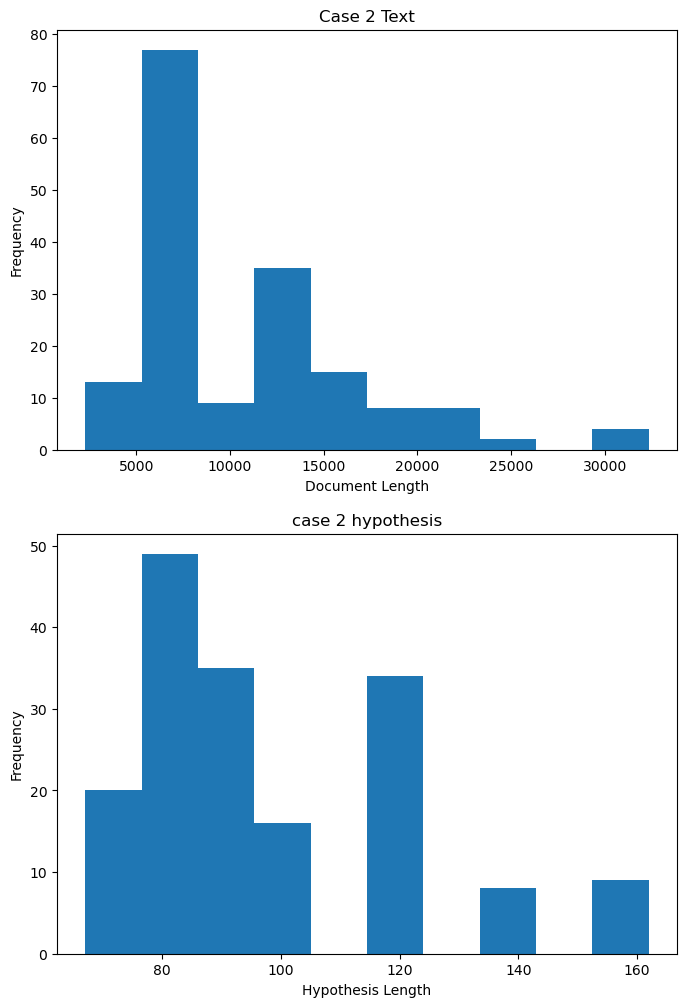

In [ ]:
# visaluizing the distibuation of hypothesis lenght and Text length
case_2_text_lengths = case_2["Text"].str.len()
case_2_Hypothesis_lengths = case_2["Hypothesis"].str.len()

fig, axs = plt.subplots(2, 1, figsize=(8, 12))

axs[0].hist(case_1_text_lengths, bins=10)
axs[0].set_title('Case 2 Text')
axs[0].set_xlabel('Document Length')
axs[0].set_ylabel('Frequency')

axs[1].hist(case_1_Hypothesis_lengths, bins=10)
axs[1].set_title('case 2 hypothesis')
axs[1].set_xlabel('Hypothesis Length')
axs[1].set_ylabel('Frequency')



plt.show;

Also the same as the previous model

so the other aproach is to invesigate the first and last 5 hypotheses in both cases and see if there are any complex words

In [ ]:
for i in range(10):
    print(case_1['Hypothesis'].iloc[i])

Receiving Party shall notify Disclosing Party in case Receiving Party is required by law, regulation or judicial process to disclose any Confidential Information.
Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information.
Agreement shall not grant Receiving Party any right to Confidential Information.
Receiving Party shall not disclose the fact that Agreement was agreed or negotiated.
Receiving Party may retain some Confidential Information even after the return or destruction of Confidential Information.
Receiving Party shall not solicit some of Disclosing Party's representatives.
Receiving Party may create a copy of some Confidential Information in some circumstances.
Receiving Party may acquire information similar to Confidential Information from a third party.
Agreement shall not grant Receiving Party any right to Confidential Information.
Receiving Party may retain some Confidential Information even after the return o

In [ ]:
for i in range(10):
    print(case_2['Hypothesis'].iloc[i])

Receiving Party shall not reverse engineer any objects which embody Disclosing Party's Confidential Information.
Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.
All Confidential Information shall be expressly identified by the Disclosing Party.
Confidential Information may include verbally conveyed information.
Receiving Party may create a copy of some Confidential Information in some circumstances.
Receiving Party shall destroy or return some Confidential Information upon the termination of Agreement.
Receiving Party shall not disclose the fact that Agreement was agreed or negotiated.
All Confidential Information shall be expressly identified by the Disclosing Party.
Receiving Party may independently develop information similar to Confidential Information.
Receiving Party shall notify Disclosing Party in case Receiving Party is required by law, regulation or judicial process to disclose any Confidential Information.


#### Conclusions and summary
 I suggest that the model missclassifed the data in the following 2 cases for diffrent expectations:


 1. The model may be suffred from overfitting to some patterns in the training dataset and cant generalize well
 2.  Due to Language complexity as the langage in these sentences might me too complex and it's difficult for the model to classify them correclty for example if there are a certain Logical connections or relactioships between sentences that were stated implicitly couldn't be captured by the model without addiontial training dataset.

### 4- Recommendation Ideas

### To improve the performance of the previous models i recommend doing the following

#### 1. using Ensemble of models :
to combine the strengths of multiple models to improve overall performance. By training multiple models with different architectures, hyperparameters,we can capture a wider range of patterns and relationships in the language.

#### 2. Use adversarial training :
to train the mdoel on adversarial examples, which are input examples that are specifically designed to confuse the model and make it give incorrect predictions.so that we can improve its robustness to different forms of input noise or variations. and adversarial examples involves modifying the input sentences in subtle ways that change the logical relationships between them while still maintaining their semantic meaning.